# Parameter identification interface
### User-interface to perform parameter identification of bioscrape/SBML models

* Simple functions to import models/data 
* Use the fast deterministic and stochastic simulators available within bioscrape
* (Optionally) Specify paramter priors, desired likelihood/cost functions 
* Create your own likelihood functions interface

## Loglikelihood Functions
Bioscrape comes with a number of built in log-likelihood functions for deterministic or stochastic parameter inference. These functions are detailed in the following notebook. First, a simple model is made to test the functions:

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

A set of N trajectories is then generated from this model, from either the same or different initial conditions, across the same or different time-windows. Gaussian noise is then added to all the samples.

In [1]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt

# Import bioscrape XML / bioscrape model object M / SBML file
# M  = bs.types.read_model_from_sbml(filename)
# M = Model('models/pid_model.xml')

# Or...Create a Model using the bioscrape API
species = ['X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), ([], ['X'], 'massaction', {'k':'k1'})]
k1 = 10.0
d1 = .2
params = [('k1', k1), ('d1', d1)]
initial_condition = {'X':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

M_original = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)
# Import data from CSV
# data = import_timeseries('test_data.csv', time_column = 2, value_column = 4, properties = {3 : 51})

M.py_initialize()

N = 10 #Number of trajectories
nT = 50 #number of timepoints
noise_std = 5 #Standar deviation of the guassian noise added onto the measurements

MultipleTimepoints = True #Different timepoints for each trajectory?
timepoint_list = []
timepoints = np.linspace(np.random.randint(0, 10), np.random.randint(10, 100), nT)
#Generate Trajectories
R = [] #Results as Pandas Dataframes
data = [] #Results will become a numpy array
MultipleInitialConditions = True #Different initial conditions for each trajectory?

X0_list = [] #multiple initial conditions will be saved for inference
for n in range(N):
    if MultipleInitialConditions:
        initial_condition = {'X': np.random.randint(0, 100)}
        X0_list.append(initial_condition)
        
    if MultipleTimepoints:
        timepoints = np.linspace(np.random.randint(0, 10, 1), np.random.randint(10, 100, 1), num = 50).flatten()
        timepoint_list.append(timepoints)
    
    M.set_species(initial_condition)
    r = py_simulate_model(timepoints, Model = M, stochastic = True)
    R.append(r)
    noisy_data = r['X'].to_numpy() + np.random.normal(loc = 0, scale = noise_std, size = nT)
    data.append(noisy_data)


In [2]:

M_original.get_parameter_values()

array([ 0.2, 10. ])

### To run the MCMC algorithm to identify parameters from the data, the following code can be used.

Sample log-like: 3572.4647351709473
Sample log-like: 3572.656509491228
Sample log-like: 3574.4725627368016
Sample log-like: 3575.462435652881
Sample log-like: 3574.2825630499497
Sample log-like: 3575.3599899205365
Sample log-like: 3574.855224937755
Sample log-like: 3575.107959272549
Sample log-like: 3576.432271463147
Sample log-like: 3575.521191546568
Sample log-like: 3574.3583082904884
Sample log-like: 3575.064807761873
Sample log-like: 3575.3385566673105
Sample log-like: 3576.204704552588
Sample log-like: 3571.9623256711325
Sample log-like: 3574.4386704357266
Sample log-like: 3575.5180534849637
Sample log-like: 3575.219016491134
Sample log-like: 3574.6426665000686
Sample log-like: 3574.862871312799
Sample log-like: 3575.3325493206885
Sample log-like: 3571.4142496455406
Sample log-like: 3572.7678441185453
Sample log-like: 3575.150207542326
Sample log-like: 3570.0804293304764
Sample log-like: 3575.334780649242
Sample log-like: 3575.915172648073
Sample log-like: 3575.3140957690644
Sampl

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


4.0 percent complete
4.5 percent complete
5.0 percent complete
5.5 percent complete
6.0 percent complete
6.5 percent complete
7.0 percent complete
7.5 percent complete
8.0 percent complete
8.5 percent complete
9.0 percent complete
9.5 percent complete
10.0 percent complete
10.5 percent complete
11.0 percent complete
11.5 percent complete
12.0 percent complete
12.5 percent complete
13.0 percent complete
13.5 percent complete
14.0 percent complete
14.5 percent complete
15.0 percent complete
15.5 percent complete
16.0 percent complete
16.5 percent complete
17.0 percent complete
17.5 percent complete
18.0 percent complete
18.5 percent complete
19.0 percent complete
19.5 percent complete
20.0 percent complete
20.5 percent complete
21.0 percent complete
21.5 percent complete
22.0 percent complete
22.5 percent complete
23.0 percent complete
23.5 percent complete
24.0 percent complete
24.5 percent complete
25.0 percent complete
25.5 percent complete
26.0 percent complete
26.5 percent complete


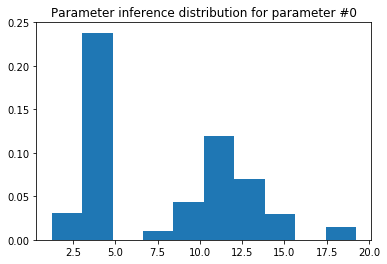

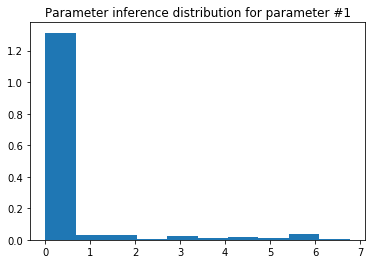

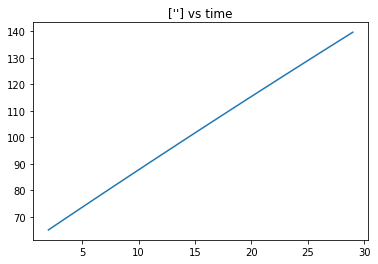

In [3]:
# Run parameter identification procedure using Python emcee -
from bioscrape.pid_interfaces import *
from bioscrape.emcee_interface import *

pid = initialize_mcmc()
pid.exp_data = np.array(data)
pid.M = M
pid.prior = {'k1' : [1e-3, 1e3],'d1' : [1e-2, 1e2]}
pid.params_to_estimate = {'k1':10, 'd1':0.2}
pid.type = 'deterministic'
pid.timepoints = timepoint_list
pid.initial_conditions = X0_list
pid.nsamples = 50
pid.nsteps = 200
pid.nwalkers = 40
fitted_model, params = pid.run_mcmc(plot_show = True)

In [4]:
fitted_model.get_parameter_values()

array([2.71313415e-03, 3.04343803e+00])

In [37]:
M_original.get_parameter_values()

array([ 0.2, 10. ])

In [5]:
from bioscrape.inference import Prior

In [6]:
p1 = Prior(STLL)

In [ ]:
p1.py_log_likelihood()